In [94]:
import tensorflow as tf
import tensorflow.python.keras as keras
from tensorflow.python.keras.layers import Conv2D, GaussianNoise
import numpy as np
import matplotlib.pyplot as plt

In [200]:
def _build_SRM_kernel():
    q = [4.0, 12.0, 2.0]
    filter1 = [[0, 0, 0, 0, 0],
               [0, -1, 2, -1, 0],
               [0, 2, -4, 2, 0],
               [0, -1, 2, -1, 0],
               [0, 0, 0, 0, 0]]
    filter2 = [[-1, 2, -2, 2, -1],
               [2, -6, 8, -6, 2],
               [-2, 8, -12, 8, -2],
               [2, -6, 8, -6, 2],
               [-1, 2, -2, 2, -1]]
    filter3 = [[0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0],
               [0, 1, -2, 1, 0],
               [0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0]]
    filter1 = np.asarray(filter1, dtype=float) / q[0]
    filter2 = np.asarray(filter2, dtype=float) / q[1]
    filter3 = np.asarray(filter3, dtype=float) / q[2]
    filters = [[filter1, filter1, filter1], [filter2, filter2, filter2], [filter3, filter3, filter3]]
    filters = np.einsum('klij->ijlk', filters)
    filters = filters.flatten()
    initializer_srm = tf.constant_initializer(filters)

    return initializer_srm

In [188]:
def gaussian_blur(img, kernel_size=11, sigma=5):
    def gauss_kernel(channels, kernel_size, sigma):
        ax = tf.range(-kernel_size // 2 + 1.0, kernel_size // 2 + 1.0)
        xx, yy = tf.meshgrid(ax, ax)
        kernel = tf.exp(-(xx ** 2 + yy ** 2) / (2.0 * sigma ** 2))
        kernel = kernel / tf.reduce_sum(kernel)
        kernel = tf.tile(kernel[..., tf.newaxis], [1, 1, channels])
        return kernel

    gaussian_kernel = gauss_kernel(tf.shape(img)[-1], kernel_size, sigma)
    gaussian_kernel = gaussian_kernel[..., tf.newaxis]
    img = tf.nn.depthwise_conv2d([img], gaussian_kernel, [1, 1, 1, 1],
                                  padding='SAME', data_format='NHWC')
    return img[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


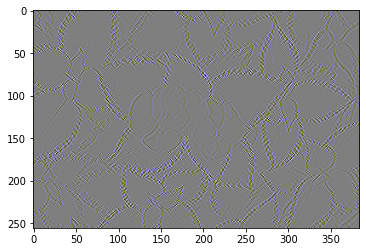

In [205]:
model = keras.Sequential()
model.add(Conv2D(3, [5, 5], trainable=False, kernel_initializer=_build_SRM_kernel(),
                                activation=None, padding='same', strides=1,
                                bias_initializer=tf.constant_initializer(0.5)))
srm = model.predict(np.array([img]))
plt.imshow(srm[0,...])

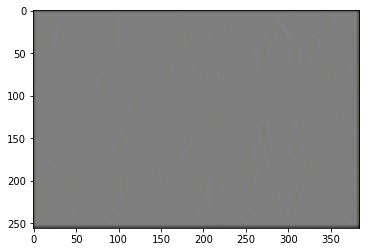

In [207]:
noise = gaussian_blur(srm[0],kernel_size=8, sigma=4)
plt.imshow(noise)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


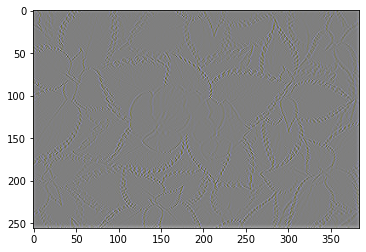

In [217]:
plt.imshow((srm[0]-noise)/2+0.5)

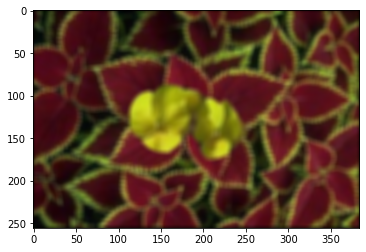

In [198]:
img = plt.imread("./img_test/1.jpg")
img = img.astype('float32') / 255.
noise = gaussian_blur(img,kernel_size=8, sigma=4)
plt.imshow(noise)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


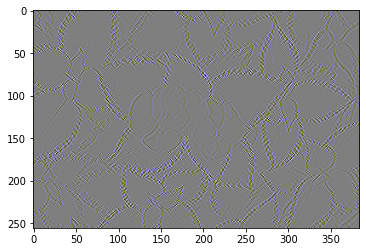